### **Digit Recognition Neural Network using Pytorch**
---

      1.   Downoading Dataset and Loading Data into Training and Testing sets:

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

      2.   Initializing Data Loaders:

In [4]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),

    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
}

      3.   Defining the Structure and Layers of the Neural Network:



In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training = self.training)
    x = self.fc2(x)

    return F.softmax(x, dim=1)

      4.   Defining the Training and Testing Functions:

In [32]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_index, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if batch_index % 20 == 0:
      print(f"Train Epoch: {epoch} [{batch_index * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_index / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(loaders['test'].dataset)
  print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%\n)")

      5.   Training the Model:

In [33]:
for epoch in range(1, 11):
  train(epoch)
  test()

Train Epoch: 1 [0/60000 (0%)]	2.303024
Train Epoch: 1 [2000/60000 (3%)]	2.287278
Train Epoch: 1 [4000/60000 (7%)]	2.207339
Train Epoch: 1 [6000/60000 (10%)]	2.005169
Train Epoch: 1 [8000/60000 (13%)]	1.924410
Train Epoch: 1 [10000/60000 (17%)]	1.891077
Train Epoch: 1 [12000/60000 (20%)]	1.837401
Train Epoch: 1 [14000/60000 (23%)]	1.811330
Train Epoch: 1 [16000/60000 (27%)]	1.798211
Train Epoch: 1 [18000/60000 (30%)]	1.691589
Train Epoch: 1 [20000/60000 (33%)]	1.660975
Train Epoch: 1 [22000/60000 (37%)]	1.624955
Train Epoch: 1 [24000/60000 (40%)]	1.686473
Train Epoch: 1 [26000/60000 (43%)]	1.635252
Train Epoch: 1 [28000/60000 (47%)]	1.646238
Train Epoch: 1 [30000/60000 (50%)]	1.640829
Train Epoch: 1 [32000/60000 (53%)]	1.631847
Train Epoch: 1 [34000/60000 (57%)]	1.650734
Train Epoch: 1 [36000/60000 (60%)]	1.663918
Train Epoch: 1 [38000/60000 (63%)]	1.676516
Train Epoch: 1 [40000/60000 (67%)]	1.589031
Train Epoch: 1 [42000/60000 (70%)]	1.634056
Train Epoch: 1 [44000/60000 (73%)]	1.577058

      6.   Evaluating the Model and making Predictions:

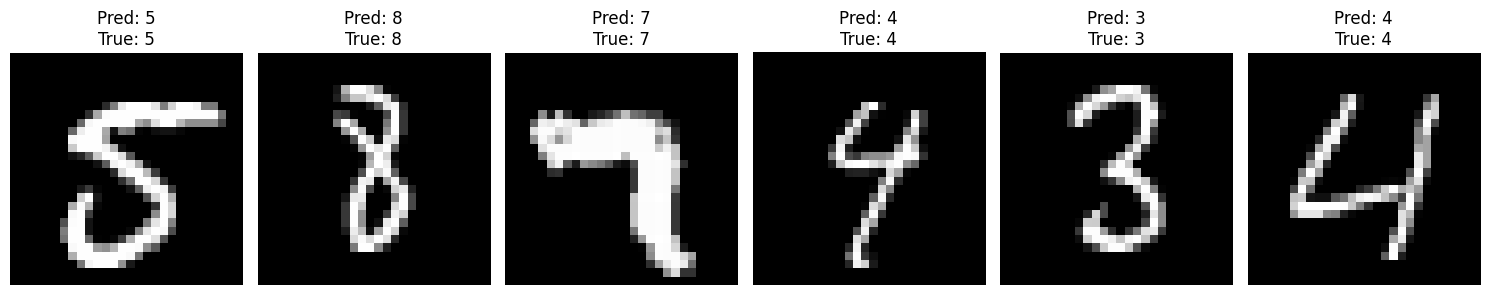

In [34]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, num_images=6):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    with torch.no_grad():
        output = model(images)
        predictions = output.argmax(dim=1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        image = images[i].cpu().squeeze().numpy()
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Pred: {predictions[i].item()}\nTrue: {labels[i].item()}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, loaders['test'])